In [1]:
import os
import pandas as pd
from tqdm import tqdm 
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import sent_tokenize, word_tokenize
from transformers import pipeline
import numpy as np

from umap import UMAP
from sklearn.cluster import KMeans

In [2]:
data_filepath = '/media/dmlab/My Passport/DATA/fomc/FOMC_statements_2021-12-31.csv'

In [3]:
df = pd.read_csv(data_filepath)
df.head()

,Date,Statement
0,2021-12-15,The Federal Reserve is committed to using its ...
1,2021-11-03,The Federal Reserve is committed to using its ...
2,2021-09-22,The Federal Reserve is committed to using its ...
3,2021-07-28,The Federal Reserve is committed to using its ...
4,2021-06-16,The Federal Reserve is committed to using its ...


In [4]:
for colname in df.columns:
    print(colname, df.iloc[0][colname])

Date 2021-12-15
Statement The Federal Reserve is committed to using its full range of tools to support the U.S. economy in this challenging time, thereby promoting its maximum employment and price stability goals.
With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have improved in recent months but continue to be affected by COVID-19. Job gains have been solid in recent months, and the unemployment rate has declined substantially. Supply and demand imbalances related to the pandemic and the reopening of the economy have continued to contribute to elevated levels of inflation. Overall financial conditions remain accommodative, in part reflecting policy measures to support the economy and the flow of credit to U.S. households and businesses.
The path of the economy continues to depend on the course of the virus. Progress on vaccinations and an easing of s

연도별 문서 개수

In [15]:
print(len(df))

43


In [4]:
df['yyyy'] = df['Date'].apply(lambda x: x[:4])
for yyyy in sorted(df['yyyy'].unique()):
    print('{}, {}'.format(yyyy, len(df[(df['yyyy']==yyyy)])))

2017, 8
2018, 8
2019, 9
2020, 10
2021, 8


문장 개수 분포

Max:28
Median=18.0
Min=7


Text(0.5, 0, 'Number of sentences')

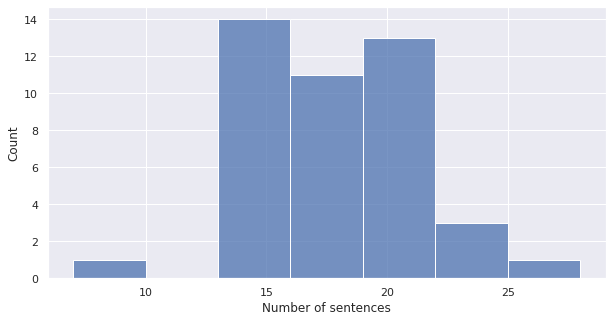

In [5]:
sns.set(rc = {'figure.figsize':(10,5)})
colname = 'num_of_sentences'

df[colname] = df['Statement'].apply(lambda x: len(sent_tokenize(x)))
print('Max:{}\nMedian={}\nMin={}'.format(df[colname].max(),df[colname].median(),df[colname].min()))

plot = sns.histplot(df[colname].values)
plt.xlabel('Number of sentences')  

단어 개수 분포

Max:771
Median=515.0
Min=157


Text(0.5, 0, 'Number of tokens')

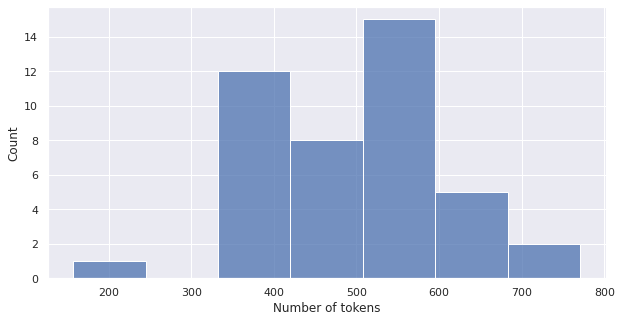

In [6]:
colname = 'num_of_tokes'

df[colname] = df['Statement'].apply(lambda x: len(word_tokenize(x)))
print('Max:{}\nMedian={}\nMin={}'.format(df[colname].max(),df[colname].median(),df[colname].min()))

plot = sns.histplot(df[colname].values)
plt.xlabel('Number of tokens')  

BERT+UMAP+K-Means

In [7]:
nlp_features = pipeline('feature-extraction')

No model was supplied, defaulted to distilbert-base-cased (https://huggingface.co/distilbert-base-cased)
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
records = []
for _, row in tqdm(df.iterrows()):
    date = row['Date']
    for sent in sent_tokenize(row['Statement']):
        feature = np.squeeze(nlp_features(sent)).mean(0) # 평균을 취하는 방법을 택함
        records.append((date, sent, feature))
sent_df = pd.DataFrame(records, columns=['date', 'sentence', 'feature'])
sent_df.head()

43it [00:12,  3.47it/s]


,date,sentence,feature
0,2021-12-15,The Federal Reserve is committed to using its ...,"[0.09516288178998071, -0.06994150150441439, 0...."
1,2021-12-15,With progress on vaccinations and strong polic...,"[0.05808704249560833, -0.1022964440099895, 0.1..."
2,2021-12-15,The sectors most adversely affected by the pan...,"[0.29767200636367, -0.05229561380886783, -0.00..."
3,2021-12-15,"Job gains have been solid in recent months, an...","[0.04969722199204721, 0.2053103659694132, 0.16..."
4,2021-12-15,Supply and demand imbalances related to the pa...,"[-0.021917731684604376, 0.1460001759908416, -0..."


UMAP

In [9]:
%%time
arr = np.vstack(sent_df['feature'].values)
embedded = UMAP(n_components=2, random_state=42).fit_transform(arr)

CPU times: user 14 s, sys: 272 ms, total: 14.3 s
Wall time: 8.73 s


without clustering

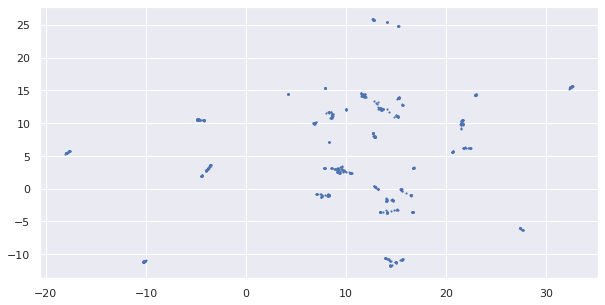

In [10]:
plt.scatter(embedded[:, 0], embedded[:, 1], marker='.', s=5)

kmeans clustering

CPU times: user 385 ms, sys: 23.9 ms, total: 409 ms
Wall time: 145 ms


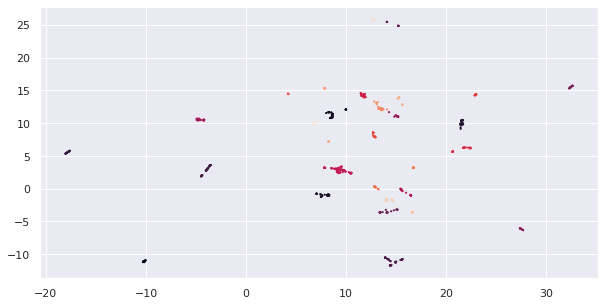

In [11]:
%%time
num_cluster = 30
labels = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=5, random_state=42).fit_predict(embedded)

plt.scatter(embedded[:, 0], embedded[:, 1], c=labels, marker='.', s=5)

In [12]:
sent_df['cluster_index'] = labels
sent_df.head()

,date,sentence,feature,cluster_index
0,2021-12-15,The Federal Reserve is committed to using its ...,"[0.09516288178998071, -0.06994150150441439, 0....",17
1,2021-12-15,With progress on vaccinations and strong polic...,"[0.05808704249560833, -0.1022964440099895, 0.1...",1
2,2021-12-15,The sectors most adversely affected by the pan...,"[0.29767200636367, -0.05229561380886783, -0.00...",1
3,2021-12-15,"Job gains have been solid in recent months, an...","[0.04969722199204721, 0.2053103659694132, 0.16...",15
4,2021-12-15,Supply and demand imbalances related to the pa...,"[-0.021917731684604376, 0.1460001759908416, -0...",1


In [13]:
sent_df[(sent_df['sentence'].apply(lambda x: 'Powell' in x))].head()

,date,sentence,feature,cluster_index
19,2021-12-15,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6
42,2021-11-03,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6
62,2021-09-22,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6
81,2021-07-28,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6
100,2021-06-16,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6


5번 클러스터: 참석자 명단이 나열된 문장들

In [16]:
temp = sent_df[(sent_df['cluster_index']==6)]
print(len(temp))
temp.head()

42


,date,sentence,feature,cluster_index
19,2021-12-15,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6
42,2021-11-03,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6
62,2021-09-22,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6
81,2021-07-28,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6
100,2021-06-16,Voting for the monetary policy action were Jer...,"[-0.04786277685721134, -0.16435505856488702, 0...",6


In [14]:
temp = sent_df[(sent_df['cluster_index']==5)]
print(len(temp))
temp.head()

43


,date,sentence,feature,cluster_index
20,2021-12-15,"Implementation Note issued December 15, 2021","[0.13970585819333792, -0.25936718968053657, 0....",5
43,2021-11-03,"Implementation Note issued November 3, 2021","[0.20753679176171622, -0.20076826338966688, 0....",5
63,2021-09-22,"Implementation Note issued September 22, 2021","[0.16760266851633787, -0.2528836727142334, 0.1...",5
82,2021-07-28,"Implementation Note issued July 28, 2021","[0.15450554116008183, -0.25206173459688824, 0....",5
101,2021-06-16,"Implementation Note issued June 16, 2021","[0.18765657775414488, -0.22532168868929148, 0....",5
